In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [172]:
shot_path = 'laser_shots'
focus_point_hole_position = 9.8
cam_pos = 18.5
hole_interval = 25 # mm

best_circle_focus = (158, 120)

In [3]:
def filter_bright_range(img: np.ndarray, threshold: int = 100) -> np.ndarray:
    bright_pixels = img > threshold
    # get smallest and largest indices of bright pixels, both in x and y direction
    x_min, x_max = np.min(np.where(bright_pixels)[0]), np.max(np.where(bright_pixels)[0])
    y_min, y_max = np.min(np.where(bright_pixels)[1]), np.max(np.where(bright_pixels)[1])
    return img[x_min:x_max, y_min:y_max]

In [158]:
def get_avg_img(filename: str, cnt: int = 5, base_dir: str = '../laser_shots/100us') -> np.ndarray:
    imgs = []
    for i in range(1, cnt + 1):
        img = cv.imread(f'{base_dir}/{filename}_{i}.png', cv.IMREAD_GRAYSCALE)
        imgs.append(img)
    return np.mean(imgs, axis=0).astype(np.uint8)

In [179]:
avg_img = get_avg_img('13h_100us')

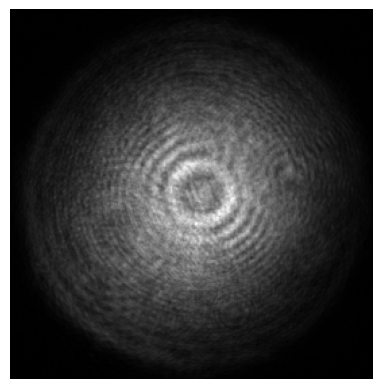

In [180]:
bright_parts = filter_bright_range(avg_img, 5)
plt.axis('off')
plt.imshow(bright_parts, cmap='gray')

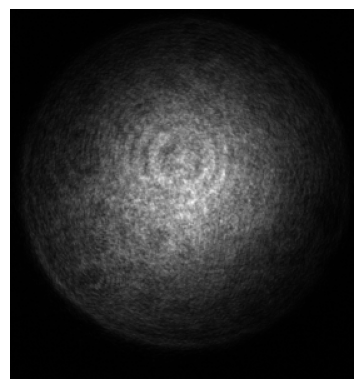

In [181]:
plt.axis('off')
plt.imshow(filter_bright_range(imgs[0], 5), cmap='gray')

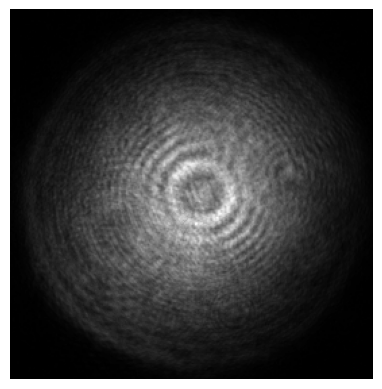

In [182]:
# turn the image into a 8-bit image
bright_parts = cv.normalize(bright_parts, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
plt.axis('off')
plt.imshow(bright_parts, cmap='gray')

In [183]:
gradient_x = cv.Sobel(bright_parts, cv.CV_64F, 1, 0, ksize=5)
gradient_y = cv.Sobel(bright_parts, cv.CV_64F, 0, 1, ksize=5)

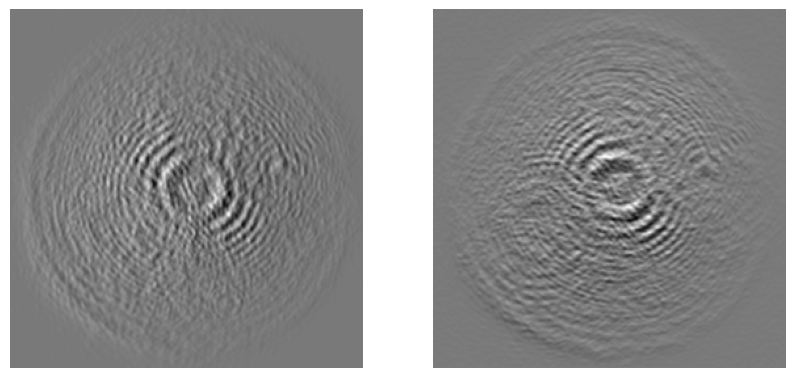

In [184]:
fig = plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(gradient_x, cmap='gray')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(gradient_y, cmap='gray')

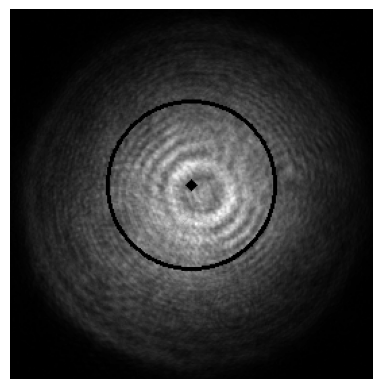

In [185]:
# there's a concentric pattern in the image, so we can use the Hough Circle Transform to detect the circles
circles = cv.HoughCircles(bright_parts, cv.HOUGH_GRADIENT, 1, 100, param1=100, param2=30, minRadius=30, maxRadius=100)
circles = np.uint16(np.around(circles))
to_show = bright_parts.copy()
best_circle = circles[0, 0]
# draw the outer circle
cv.circle(to_show, (best_circle[0], best_circle[1]), best_circle[2], (0, 255, 0), 2)
# draw the center of the circle
cv.circle(to_show, (best_circle[0], best_circle[1]), 2, (0, 0, 255), 3)
plt.axis('off')
plt.imshow(to_show, cmap='gray')

In [152]:
best_circle

array([158, 120,  62], dtype=uint16)

In [166]:
dist_to_analyze = ['13h', 'focus', '5h', '2h']

In [167]:
avg_imgs = [get_avg_img(f'{dist}_100us') for dist in dist_to_analyze]
avg_imgs = [filter_bright_range(img, 5) for img in avg_imgs]

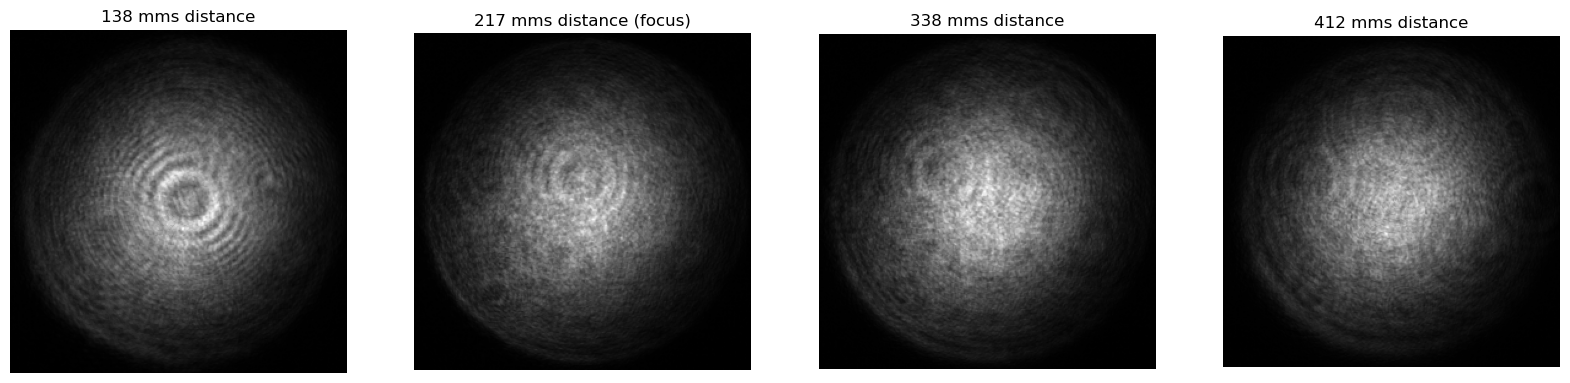

In [211]:
# plot all the images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, img in enumerate(avg_imgs):
    pos = dist_to_analyze[i]
    if pos == 'focus':
        hole_cnt = 9.8
    else:
        hole_cnt = int(pos[:-1])
    axes[i].axis('off')
    axes[i].imshow(img, cmap='gray')
    title = str(round((cam_pos - hole_cnt) * hole_interval)) + ' mms distance' + (' (focus)' if pos == 'focus' else '')
    axes[i].set_title(title)

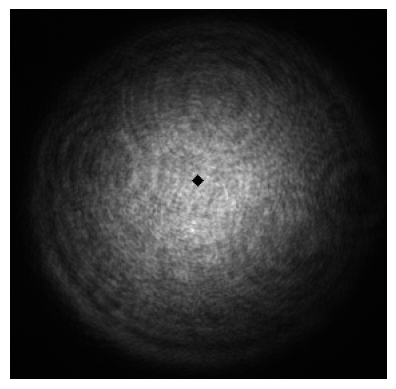

In [207]:
test_x, test_y = 128, 140
to_show = avg_imgs[3].copy()
cv.circle(to_show, (test_y, test_x), 2, (0, 0, 255), 3)
plt.axis('off')
plt.imshow(to_show, cmap='gray')

In [208]:
center_points = [(136, 143), (120, 138), (128, 140), (128, 140)]

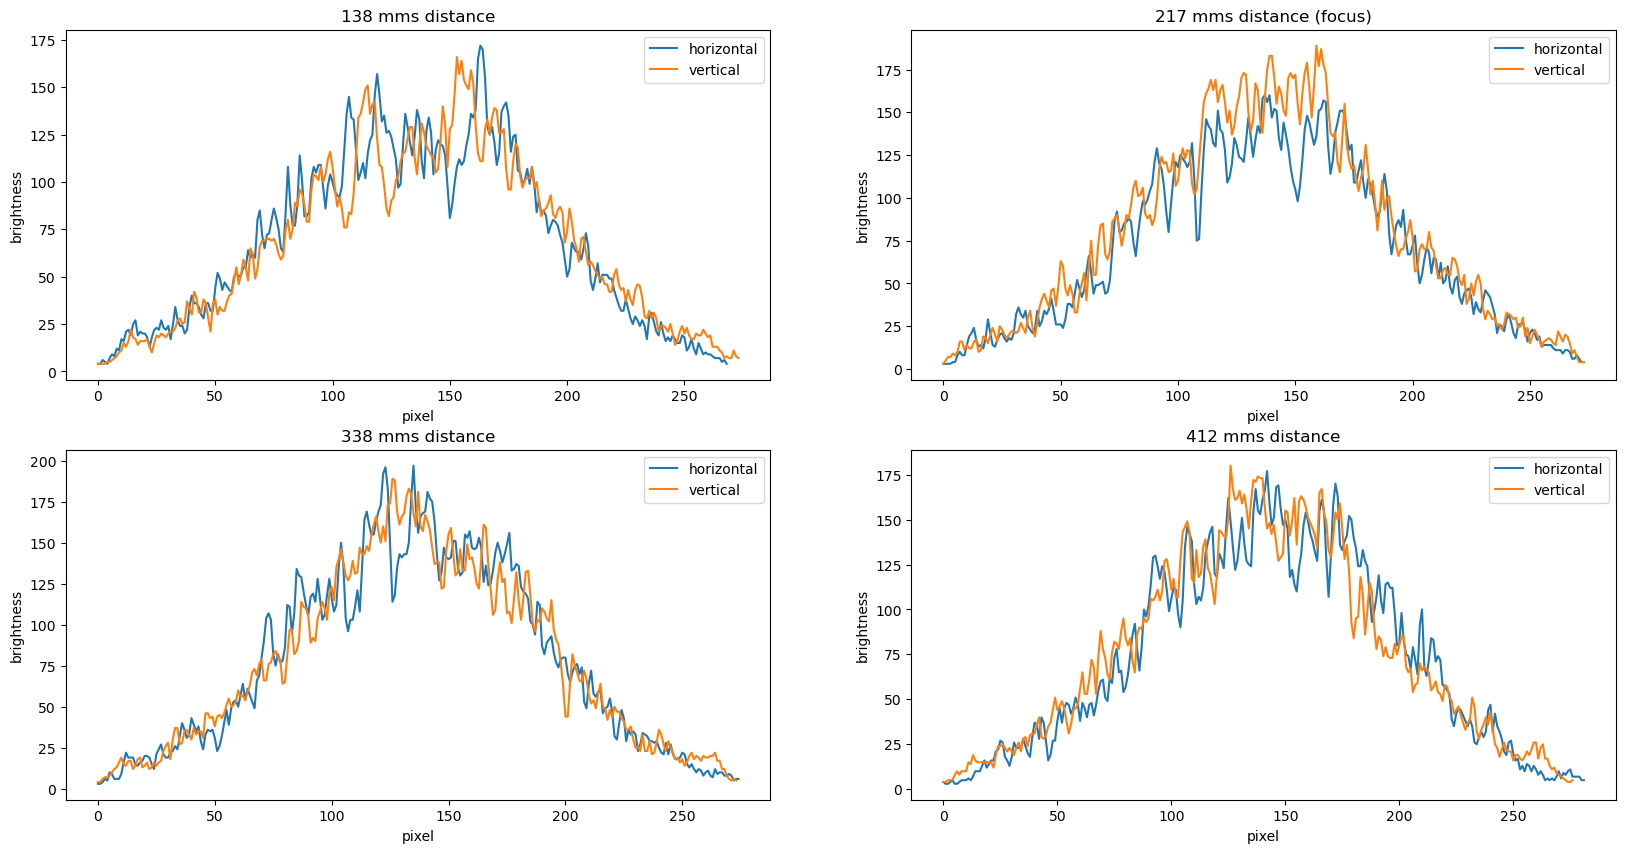

In [210]:
distributions = []
for i, img in enumerate(avg_imgs):
    mid_x, mid_y = center_points[i]
    horizontal_distribution = img[mid_x, :]
    vertical_distribution = img[:, mid_y]
    distributions.append((horizontal_distribution, vertical_distribution))
# plot the distributions in 2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for i, (dist, ax) in enumerate(zip(distributions, axes.flatten())):
    pos = dist_to_analyze[i]
    if pos == 'focus':
        hole_cnt = 9.8
    else:
        hole_cnt = int(pos[:-1])
    ax.plot(dist[0])
    ax.plot(dist[1])
    title = str(round((cam_pos - hole_cnt) * hole_interval)) + ' mms distance' + (' (focus)' if pos == 'focus' else '')
    ax.set_title(title)
    ax.set_xlabel('pixel')
    ax.set_ylabel('brightness')
    ax.legend(['horizontal', 'vertical'])

# store the plot in a file
# plt.savefig('distributions_manual_midpoint.png')